<a href="https://colab.research.google.com/github/ofri09bs/Phishing-URL-detector/blob/main/Phishing_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Initial data analysis:

total URLs: 549346
missing values:
 URL      0
Label    0
dtype: int64
                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad
5               smilesvoegol.servebbs.org/voegol.php   bad
6  premierpaymentprocessing.com/includes/boleto-2...   bad
7  myxxxcollection.com/v1/js/jih321/bpd.com.do/do...   bad
8                                super1000.info/docs   bad
9  horizonsgallery.com/js/bin/ssl1/_id/www.paypal...   bad


<Axes: xlabel='Label', ylabel='count'>

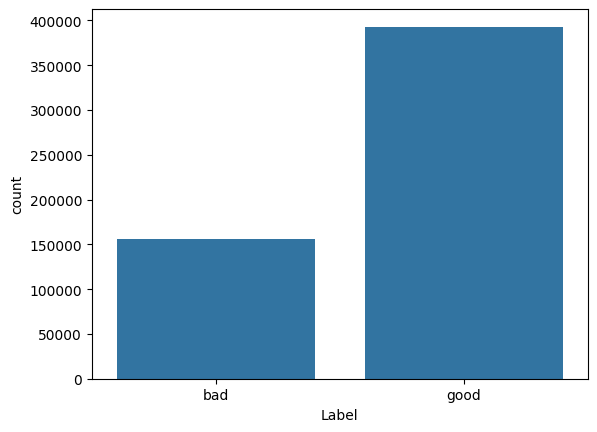

In [2]:
import pandas as pd
import seaborn as sns
df = pd.read_csv('/content/drive/MyDrive/Phishing project/phishing_site_urls.csv')
  #change this according to your folderprint(f"total URLs: {len(df)}")
print(f"missing values:\n {df.isna().sum()}")
print(df.head(10))
sns.countplot(data=df , x='Label')

start adding important features and parsing the URL.

In [22]:
from urllib.parse import urlparse
suswords = [
    'login', 'signin', 'verify', 'account', 'password',
    'secure', 'security', 'update', 'confirm', 'banking',
    'paypal','support', 'admin', 'service', 'webscr','bank'
]

sus_suffixes = [
    '.tk', '.ml', '.ga', '.cf', '.gq', '.zip', '.ru', '.xyz','.php'
]

def count_words(url):
  count = 0
  for word in suswords:
    if word in url.lower():
      count += 1
  return count

def has_sus_suffix(url):
  for suffix in sus_suffixes:
    if url.lower().endswith(suffix):
      return 1
  return 0

def extract_features(url):
  features = {}
  features['length'] = len(url)
  features['count_dots'] = url.count('.')
  features['count_dashes'] = url.count('-')
  features['has_https'] = int(url.startswith('https'))
  features['has_at'] = int('@' in url)
  features['has_www'] = int(url.startswith('www'))
  features['has_ip'] = int(url.replace('.', '').isdigit())
  parsed_url = urlparse(url)
  hostname = parsed_url.hostname if parsed_url.hostname else ''
  parts = hostname.split('.')
  num_subdomains = len(parts) - 2
  features['num_of_subdomains'] = max(0, num_subdomains)
  features['path_slashes'] = parsed_url.path.count('/')
  features['double_slash_in_path'] = int('//' in parsed_url.path)
  features['suswords_count'] = count_words(url)
  features['has_sus_suffix'] = has_sus_suffix(url)

  return features

features_list = df['URL'].apply(extract_features)
x_features = pd.DataFrame(features_list.tolist())
y_features = df['Label']

Splitting the data into training and testing and train the model

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , confusion_matrix, classification_report, precision_score, recall_score, f1_score

x_train, x_test, y_train, y_test = train_test_split(x_features, y_features, test_size=0.2, random_state=42)

# Fill missing values with 0
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

model = RandomForestClassifier(n_estimators=100,random_state=42,class_weight='balanced')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

model resaults:

              precision    recall  f1-score   support

         bad       0.61      0.75      0.67     31200
        good       0.89      0.81      0.85     78670

    accuracy                           0.80    109870
   macro avg       0.75      0.78      0.76    109870
weighted avg       0.81      0.80      0.80    109870



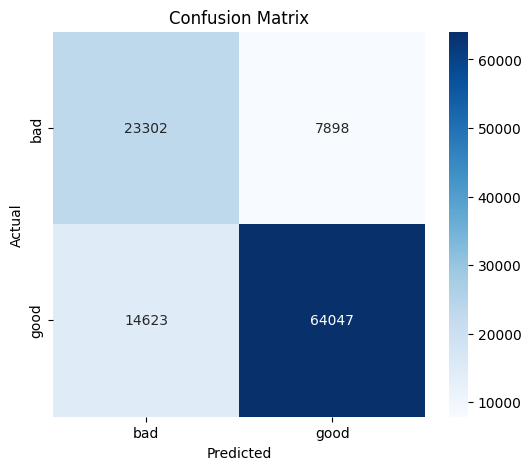

<Axes: >

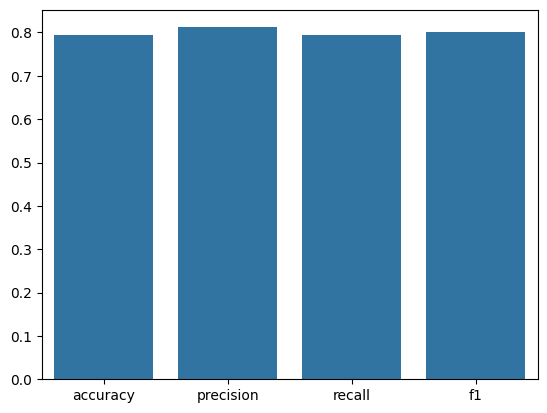

In [24]:
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
classes = ['bad', 'good']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
scores = {"accuracy":accuracy_score(y_test, y_pred),"precision": precision_score(y_test, y_pred, average='weighted'),"recall": recall_score(y_test, y_pred, average='weighted'),"f1": f1_score(y_test, y_pred, average='weighted')}
sns.barplot(data=scores)

feature importances

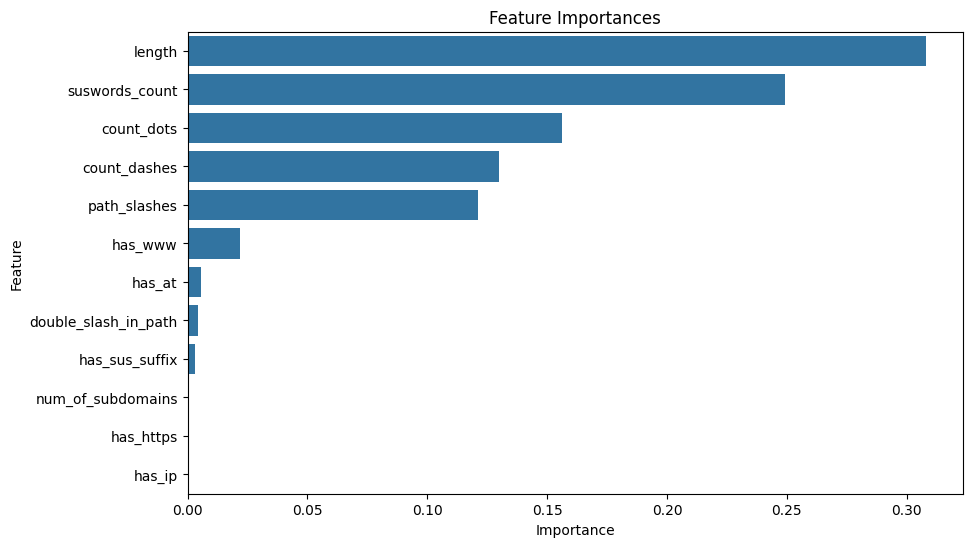

In [20]:
importances = model.feature_importances_
feature_names = x_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

In [25]:
#saving the model
import joblib

joblib.dump(model, "/content/drive/MyDrive/Phishing project/phishing_model4.pkl")

['/content/drive/MyDrive/Phishing project/phishing_model4.pkl'] #change this according to your folder